<a href="https://colab.research.google.com/github/kk20krishna/Intelligent-Sourcing/blob/main/Intelligent_Sourcing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intelligent Sourcing**

Created by Krishna Kumar Sankaran Kutty

# Housekeeping

In [ ]:
#!pip install pulp xlsxwriter

In [ ]:
# Import PuLP modeler functions
from pulp import *
import pandas as pd
from io import StringIO
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt

# Input Data

## Business Strategy Prioritization

In [ ]:
Weightage_Cost = 0.5
Weightage_Priority = 1

## Warehouse Data

In [ ]:
# Read Warehouse data CSV
stock_data_csv = """
Warehouse,Product#1,Product#2,Product#3,Product#4
Warehouse#1,5,1,5,1
Warehouse#2,5,5,1,15
Warehouse#3,2,5,10,0
Warehouse#4,4,5,0,2
"""

stock_data = pd.read_csv(StringIO(stock_data_csv))
stock_data

,Warehouse,Product#1,Product#2,Product#3,Product#4
0,Warehouse#1,5,1,5,1
1,Warehouse#2,5,5,1,15
2,Warehouse#3,2,5,10,0
3,Warehouse#4,4,5,0,2


In [ ]:
# Creates a dictionary of the available stock of each product in each warehouse

Warehouses = stock_data['Warehouse'].to_list()
Products = stock_data.columns[1:]

stock = makeDict([Warehouses, Products], stock_data.drop('Warehouse', axis=1).values, default=0)

## Order Data

In [ ]:
# Read Demand data CSV
order_data_csv = """
Order,Product#1,Product#2,Product#3,Product#4
Order#1,2,3,2,3
Order#2,4,1,4,1
Order#3,5,3,5,3
Order#4,2,2,2,2
"""

order_data = pd.read_csv(StringIO(order_data_csv))
order_data

,Order,Product#1,Product#2,Product#3,Product#4
0,Order#1,2,3,2,3
1,Order#2,4,1,4,1
2,Order#3,5,3,5,3
3,Order#4,2,2,2,2


In [ ]:
for col in order_data.columns[1:]:
  print(col, order_data[col].sum())

Product#1 13
Product#2 9
Product#3 13
Product#4 9


In [ ]:
# Creates a dictionary of the number of each product in each deamnd

Orders = order_data['Order'].to_list()

quantity = makeDict([Orders, Products], order_data.drop('Order', axis=1).values, default=0)

## Cost Details

In [ ]:
# Read Demand data CSV
cost_data_csv = "Warehouse,Order,Product,Cost\n"

rng = np.random.RandomState(seed=42)

for w in Warehouses:
  for o in Orders:
    for p in Products:
      q = rng.randint(1, 1000)
      cost_data_csv += f"{w},{o},{p},{q}\n"

cost_data = pd.read_csv(StringIO(cost_data_csv))
cost_data

,Warehouse,Order,Product,Cost
0,Warehouse#1,Order#1,Product#1,103
1,Warehouse#1,Order#1,Product#2,436
2,Warehouse#1,Order#1,Product#3,861
3,Warehouse#1,Order#1,Product#4,271
4,Warehouse#1,Order#2,Product#1,107
...,...,...,...,...
59,Warehouse#4,Order#3,Product#4,819
60,Warehouse#4,Order#4,Product#1,647
61,Warehouse#4,Order#4,Product#2,21
62,Warehouse#4,Order#4,Product#3,841


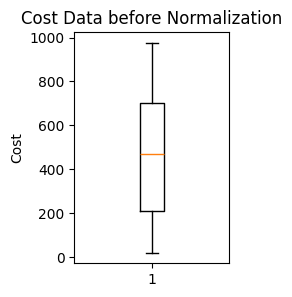

In [ ]:
plt.figure(figsize=(2,3))
plt.boxplot(cost_data['Cost'])
plt.title('Cost Data before Normalization')
plt.ylabel('Cost')
plt.show()

In [ ]:
# Calculate the minimum and maximum cost
min_cost = cost_data['Cost'].min()
max_cost = cost_data['Cost'].max()

# Normalize the 'Cost' column
cost_data['Cost'] = (cost_data['Cost'] - min_cost) / (max_cost - min_cost)

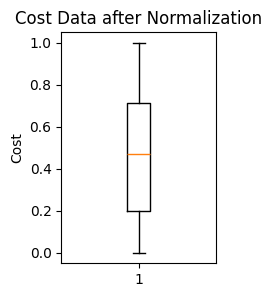

In [ ]:
plt.figure(figsize=(2,3))
plt.boxplot(cost_data['Cost'])
plt.title('Cost Data after Normalization')
plt.ylabel('Cost')
plt.show()

In [ ]:
# Creates a dictionary of the cost for each Warehouse, Order and Product Combination

# Reshape cost_data["Cost"].values to match the dimensions of Warehouses, Orders, Products
cost_values = cost_data["Cost"].values.reshape(len(Warehouses), len(Orders), len(Products))
cost_values.shape

cost = makeDict([Warehouses, Orders, Products], cost_values, default=0)

## Priority

In [ ]:
# Read Priority data CSV
priority_data_csv = """
Warehouse,Priority
Warehouse#1,100
Warehouse#2,200
Warehouse#3,300
Warehouse#4,1000
"""

priority_data = pd.read_csv(StringIO(priority_data_csv))
priority_data

,Warehouse,Priority
0,Warehouse#1,100
1,Warehouse#2,200
2,Warehouse#3,300
3,Warehouse#4,1000


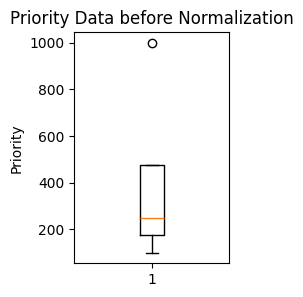

In [ ]:
plt.figure(figsize=(2,3))
plt.boxplot(priority_data['Priority'])
plt.title('Priority Data before Normalization')
plt.ylabel('Priority')
plt.show()

In [ ]:
# Calculate the minimum and maximum cost
min_cost = priority_data['Priority'].min()
max_cost = priority_data['Priority'].max()

# Normalize the 'Cost' column
priority_data['Priority'] = (priority_data['Priority'] - min_cost) / (max_cost - min_cost)

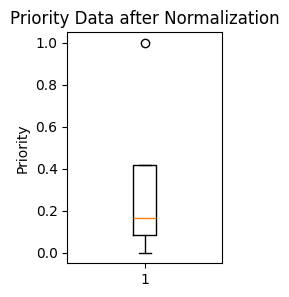

In [ ]:
plt.figure(figsize=(2,3))
plt.boxplot(priority_data['Priority'])
plt.title('Priority Data after Normalization')
plt.ylabel('Priority')
plt.show()

In [ ]:
# Creates a dictionary of the priority for warehouse

priority = makeDict([Warehouses], priority_data.drop('Warehouse', axis=1).values.reshape(len(Warehouses)), default=0)
priority

defaultdict(<function pulp.utilities.__makeDict.<locals>.<lambda>()>,
            {'Warehouse#1': 0.0,
             'Warehouse#2': 0.1111111111111111,
             'Warehouse#3': 0.2222222222222222,
             'Warehouse#4': 1.0})

# Linear Optimization

## Define Variables - Routes

In [ ]:
# Creates a list of tuples containing all the possible routes for transport
routes = [(w, o, s) for w in Warehouses for o in Orders for s in Products]

In [ ]:
# A dictionary called 'Vars' is created to contain the referenced variables(the routes)
variable = LpVariable.dicts("Route", (Warehouses, Orders, Products), 0, None, LpInteger)

for w in Warehouses:
  for o in Orders:
    for p in Products:
      print(f'The variable for transporting {p} from {w} to {o} is {variable[w][o][p]}')

The variable for transporting Product#1 from Warehouse#1 to Order#1 is Route_Warehouse#1_Order#1_Product#1
The variable for transporting Product#2 from Warehouse#1 to Order#1 is Route_Warehouse#1_Order#1_Product#2
The variable for transporting Product#3 from Warehouse#1 to Order#1 is Route_Warehouse#1_Order#1_Product#3
The variable for transporting Product#4 from Warehouse#1 to Order#1 is Route_Warehouse#1_Order#1_Product#4
The variable for transporting Product#1 from Warehouse#1 to Order#2 is Route_Warehouse#1_Order#2_Product#1
The variable for transporting Product#2 from Warehouse#1 to Order#2 is Route_Warehouse#1_Order#2_Product#2
The variable for transporting Product#3 from Warehouse#1 to Order#2 is Route_Warehouse#1_Order#2_Product#3
The variable for transporting Product#4 from Warehouse#1 to Order#2 is Route_Warehouse#1_Order#2_Product#4
The variable for transporting Product#1 from Warehouse#1 to Order#3 is Route_Warehouse#1_Order#3_Product#1
The variable for transporting Product

## Create cost function

In [ ]:
# Creates the 'prob' variable to contain the problem data
prob = LpProblem("Distribution Problem", LpMinimize)

/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [ ]:
# The objective function is added to 'prob' first
prob += (
          lpSum(  [ variable[w][o][p]
                    * (
                        (Weightage_Cost * cost[w][o][p])
                         +
                        (Weightage_Priority *-priority[w])
                      )
                    for (w,o,p) in routes
                  ]
                ),
          "Sum_of_Costs"
        )

prob

Distribution_Problem:
MINIMIZE
0.04293193717277487*Route_Warehouse#1_Order#1_Product#1 + 0.21727748691099477*Route_Warehouse#1_Order#1_Product#2 + 0.4397905759162304*Route_Warehouse#1_Order#1_Product#3 + 0.13089005235602094*Route_Warehouse#1_Order#1_Product#4 + 0.04502617801047121*Route_Warehouse#1_Order#2_Product#1 + 0.026701570680628273*Route_Warehouse#1_Order#2_Product#2 + 0.35602094240837695*Route_Warehouse#1_Order#2_Product#3 + 0.31099476439790574*Route_Warehouse#1_Order#3_Product#1 + 0.05287958115183246*Route_Warehouse#1_Order#3_Product#2 + 0.23350785340314137*Route_Warehouse#1_Order#3_Product#3 + 0.10157068062827225*Route_Warehouse#1_Order#3_Product#4 + 0.16230366492146597*Route_Warehouse#1_Order#4_Product#1 + 0.2293193717277487*Route_Warehouse#1_Order#4_Product#2 + 0.03507853403141361*Route_Warehouse#1_Order#4_Product#3 + 0.18429319371727748*Route_Warehouse#1_Order#4_Product#4 + -0.06974985456660848*Route_Warehouse#2_Order#1_Product#1 + 0.3344386271087842*Route_Warehouse#2_Orde

## Stock Constraints

In [ ]:
# The stock constraints are added to prob for each Warehouse

for w in Warehouses:
  for p in Products:
    prob += (
        lpSum([variable[w][o][p] for o in Orders ]) <= stock[w][p],
        f"Sum_of_{p}_out_of_{w}"
    )

## Order Constraints

In [ ]:
# Quantity constrainsts are added for each Order

for o in Orders:
  for p in Products:
    prob += (
        lpSum([variable[w][o][p] for w in Warehouses ]) == quantity[o][p],
        f"Sum_of_{p}_sent_to_{o}"
    )

## Print Optimization Problem

In [ ]:
prob.name

'Distribution_Problem'

In [ ]:
prob.numVariables()

64

In [ ]:
prob.numConstraints()

32

In [ ]:
prob.objective

0.04293193717277487*Route_Warehouse#1_Order#1_Product#1 + 0.21727748691099477*Route_Warehouse#1_Order#1_Product#2 + 0.4397905759162304*Route_Warehouse#1_Order#1_Product#3 + 0.13089005235602094*Route_Warehouse#1_Order#1_Product#4 + 0.04502617801047121*Route_Warehouse#1_Order#2_Product#1 + 0.026701570680628273*Route_Warehouse#1_Order#2_Product#2 + 0.35602094240837695*Route_Warehouse#1_Order#2_Product#3 + 0.31099476439790574*Route_Warehouse#1_Order#3_Product#1 + 0.05287958115183246*Route_Warehouse#1_Order#3_Product#2 + 0.23350785340314137*Route_Warehouse#1_Order#3_Product#3 + 0.10157068062827225*Route_Warehouse#1_Order#3_Product#4 + 0.16230366492146597*Route_Warehouse#1_Order#4_Product#1 + 0.2293193717277487*Route_Warehouse#1_Order#4_Product#2 + 0.03507853403141361*Route_Warehouse#1_Order#4_Product#3 + 0.18429319371727748*Route_Warehouse#1_Order#4_Product#4 + -0.06974985456660848*Route_Warehouse#2_Order#1_Product#1 + 0.3344386271087842*Route_Warehouse#2_Order#1_Product#2 + 0.2255381035485

In [ ]:
prob.constraints

OrderedDict([('Sum_of_Product#1_out_of_Warehouse#1',
              1*Route_Warehouse#1_Order#1_Product#1 + 1*Route_Warehouse#1_Order#2_Product#1 + 1*Route_Warehouse#1_Order#3_Product#1 + 1*Route_Warehouse#1_Order#4_Product#1 + -5 <= 0),
             ('Sum_of_Product#2_out_of_Warehouse#1',
              1*Route_Warehouse#1_Order#1_Product#2 + 1*Route_Warehouse#1_Order#2_Product#2 + 1*Route_Warehouse#1_Order#3_Product#2 + 1*Route_Warehouse#1_Order#4_Product#2 + -1 <= 0),
             ('Sum_of_Product#3_out_of_Warehouse#1',
              1*Route_Warehouse#1_Order#1_Product#3 + 1*Route_Warehouse#1_Order#2_Product#3 + 1*Route_Warehouse#1_Order#3_Product#3 + 1*Route_Warehouse#1_Order#4_Product#3 + -5 <= 0),
             ('Sum_of_Product#4_out_of_Warehouse#1',
              1*Route_Warehouse#1_Order#1_Product#4 + 1*Route_Warehouse#1_Order#2_Product#4 + 1*Route_Warehouse#1_Order#3_Product#4 + 1*Route_Warehouse#1_Order#4_Product#4 + -1 <= 0),
             ('Sum_of_Product#1_out_of_Warehouse#2',

In [ ]:
prob

Distribution_Problem:
MINIMIZE
0.04293193717277487*Route_Warehouse#1_Order#1_Product#1 + 0.21727748691099477*Route_Warehouse#1_Order#1_Product#2 + 0.4397905759162304*Route_Warehouse#1_Order#1_Product#3 + 0.13089005235602094*Route_Warehouse#1_Order#1_Product#4 + 0.04502617801047121*Route_Warehouse#1_Order#2_Product#1 + 0.026701570680628273*Route_Warehouse#1_Order#2_Product#2 + 0.35602094240837695*Route_Warehouse#1_Order#2_Product#3 + 0.31099476439790574*Route_Warehouse#1_Order#3_Product#1 + 0.05287958115183246*Route_Warehouse#1_Order#3_Product#2 + 0.23350785340314137*Route_Warehouse#1_Order#3_Product#3 + 0.10157068062827225*Route_Warehouse#1_Order#3_Product#4 + 0.16230366492146597*Route_Warehouse#1_Order#4_Product#1 + 0.2293193717277487*Route_Warehouse#1_Order#4_Product#2 + 0.03507853403141361*Route_Warehouse#1_Order#4_Product#3 + 0.18429319371727748*Route_Warehouse#1_Order#4_Product#4 + -0.06974985456660848*Route_Warehouse#2_Order#1_Product#1 + 0.3344386271087842*Route_Warehouse#2_Orde

In [ ]:
#Check for duplicate variable names
prob.checkDuplicateVars()

#Check for unused constraint names
prob.unusedConstraintName()

'_C1'

## Solve

In [ ]:
# The problem data is written to an .lp file
#prob.writeLP("DistributionProblem.lp")

# The problem is solved using PuLP's choice of Solver
prob.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])


Status: Optimal


## Detailed Report

In [ ]:
## Detailed Report
print("=================================")
print("        Detailed Report:")
print("=================================")

print("\n       Setup Report:")
print("=================================")
print('Warehouses:')
for w in Warehouses:
    print(w)
print('\nOrders:')
for o in Orders:
    print(o)
print('\nProducts:')
for p in Products:
    print(p)



print("\n      Inventory Report:")
print("=================================")
for w in Warehouses:
    print(f"Warehouse {w}:")
    for p in Products:
        print(f"  Product {p}: {stock[w][p]} units")

print("\n       Demand Report:")
print("=================================")
for o in Orders:
    print(f"Order {o}:")
    for p in Products:
        print(f"  Product {p}: {quantity[o][p]} units")

print("\n       Cost Report:")
print("=================================")
for w in Warehouses:
    print(f"Warehouse {w}:")
    for o in Orders:
        print(f"  Order {o}:")
        for p in Products:
            print(f"    Product {p}: {cost[w][o][p]}")

print("\n       Priority Report:")
print("=================================")
for w in Warehouses:
    print(f"Warehouse {w}:")
    print(f"  Priority: {priority[w]}")



print("\n   Fulfillment Report:")
print("========================")

print("\nSupply from each Warehouse to each Order:")
for w in Warehouses:
    print(f"Warehouse {w}:")
    for p in Products:
        for o in Orders:
            route_var = variable[w][o][p]
            if route_var.varValue > 0:
                print(f"  supplies {route_var.varValue} units of {p}")
                print(f"    to Order {o}")

print("\nUnfulfilled Demand:")
unfulfilled_flag = False
for o in Orders:
    for p in Products:
        total_received = sum(variable[w][o][p].varValue for w in Warehouses)
        unfulfilled = quantity[o][p] - total_received
        if unfulfilled > 0:
            print(f"Order {o}: Unfulfilled demand for {p} : {unfulfilled}")
if unfulfilled_flag is False:
    print("All orders are fulfilled")



print("\n Validation Report:")
print("========================")

print("\nValidation - Warehouse level:")
for w in Warehouses:
  print(f"Warehouse {w}:")
  for p in Products:
    total_supplied = sum(variable[w][o][p].varValue for o in Orders)

    if total_supplied > stock[w][p]:
      print(f"ERROR!!! - Warehouse {w}:")
      print(f"  Product {p}: Shipped ({total_supplied} units) is > than Stock ({stock[w][p]} units)")

    print(f"  Product {p}: Shipped ({total_supplied} units) is <= than Stock ({stock[w][p]} units). Remaining is {stock[w][p] - total_supplied}")

print("\nValidation - Order level:")
for o in Orders:
  print(f"Order {w}:")
  for p in Products:
    total_received= sum(variable[w][o][p].varValue for w in Warehouses)

    if total_received != quantity[o][p]:
      print(f"ERROR!!! - Order {o}:")
      print(f"  Product {p}: Received ({total_received} units) is != than Quantity ({quantity[o][p]} units)")

    print(f"  Product {p}: Received ({total_received} units) is = than Quantity ({quantity[o][p]} units)")


#print(f"\nTotal Cost: {value(prob.objective)}")

        Detailed Report:

       Setup Report:
Warehouses:
Warehouse#1
Warehouse#2
Warehouse#3
Warehouse#4

Orders:
Order#1
Order#2
Order#3
Order#4

Products:
Product#1
Product#2
Product#3
Product#4

      Inventory Report:
Warehouse Warehouse#1:
  Product Product#1: 5 units
  Product Product#2: 1 units
  Product Product#3: 5 units
  Product Product#4: 1 units
Warehouse Warehouse#2:
  Product Product#1: 5 units
  Product Product#2: 5 units
  Product Product#3: 1 units
  Product Product#4: 15 units
Warehouse Warehouse#3:
  Product Product#1: 2 units
  Product Product#2: 5 units
  Product Product#3: 10 units
  Product Product#4: 0 units
Warehouse Warehouse#4:
  Product Product#1: 4 units
  Product Product#2: 5 units
  Product Product#3: 0 units
  Product Product#4: 2 units

       Demand Report:
Order Order#1:
  Product Product#1: 2 units
  Product Product#2: 3 units
  Product Product#3: 2 units
  Product Product#4: 3 units
Order Order#2:
  Product Product#1: 4 units
  Product Product#2:

# Fulfillment Solution

In [ ]:
fulfillment_solution = []

for w in Warehouses:
    for p in Products:
        for o in Orders:
            fulfillment_solution.append({
                "Warehouse": w,
                "Product": p,
                "Order": o,
                "Supply Quantity": variable[w][o][p].varValue
            })

fulfillment_solution = pd.DataFrame(fulfillment_solution)
fulfillment_solution

,Warehouse,Product,Order,Supply Quantity
0,Warehouse#1,Product#1,Order#1,0.0
1,Warehouse#1,Product#1,Order#2,4.0
2,Warehouse#1,Product#1,Order#3,0.0
3,Warehouse#1,Product#1,Order#4,0.0
4,Warehouse#1,Product#2,Order#1,0.0
...,...,...,...,...
59,Warehouse#4,Product#3,Order#4,0.0
60,Warehouse#4,Product#4,Order#1,0.0
61,Warehouse#4,Product#4,Order#2,0.0
62,Warehouse#4,Product#4,Order#3,0.0


# Stock Status

In [ ]:
warehouse_stock_status = []

for w in Warehouses:
    for p in Products:
        warehouse_stock_status.append({
            "Warehouse": w,
            "Product": p,
            "Initial Stock": stock[w][p],
            "Supplied Stock": sum(variable[w][o][p].varValue for o in Orders),
            "Remaining Stock": stock[w][p] - sum(variable[w][o][p].varValue for o in Orders)
        })

warehouse_stock_status = pd.DataFrame(fulfillment_solution)
warehouse_stock_status

,Warehouse,Product,Order,Supply Quantity
0,Warehouse#1,Product#1,Order#1,0.0
1,Warehouse#1,Product#1,Order#2,4.0
2,Warehouse#1,Product#1,Order#3,0.0
3,Warehouse#1,Product#1,Order#4,0.0
4,Warehouse#1,Product#2,Order#1,0.0
...,...,...,...,...
59,Warehouse#4,Product#3,Order#4,0.0
60,Warehouse#4,Product#4,Order#1,0.0
61,Warehouse#4,Product#4,Order#2,0.0
62,Warehouse#4,Product#4,Order#3,0.0


# Write out all data to file

In [ ]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Intelligent Sourcing.xlsx', engine='xlsxwriter')

# Write each DataFrame to a different worksheet.
stock_data.to_excel(writer, sheet_name='Stock Data', index=False)
order_data.to_excel(writer, sheet_name='Order Data', index=False)
cost_data.to_excel(writer, sheet_name='Cost Data', index=False)
priority_data.to_excel(writer, sheet_name='Priority Data', index=False)
fulfillment_solution.to_excel(writer, sheet_name='Fulfillment Solution', index=False)
warehouse_stock_status.to_excel(writer, sheet_name='Warehouse Stock Status', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.close()

# Gradio

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import pandas as pd
from pulp import *
from io import StringIO
import numpy as np
import xlsxwriter

# Function to process the inputs and execute the optimization
def process_data(stock_data, order_data, cost_data, priority_data):
    try:
        # Convert inputs to DataFrames
        stock_data = pd.DataFrame(stock_data, columns=["Warehouse", "Product#1", "Product#2", "Product#3", "Product#4"])
        order_data = pd.DataFrame(order_data, columns=["Order", "Product#1", "Product#2", "Product#3", "Product#4"])
        cost_data = pd.DataFrame(cost_data, columns=["Warehouse", "Order", "Product", "Cost"])
        priority_data = pd.DataFrame(priority_data, columns=["Warehouse", "Priority"])

        # Convert numeric columns to appropriate types
        for col in stock_data.columns[1:]:
            stock_data[col] = pd.to_numeric(stock_data[col], errors='coerce')

        for col in order_data.columns[1:]:
            order_data[col] = pd.to_numeric(order_data[col], errors='coerce')

        cost_data["Priority"] = pd.to_numeric(cost_data["Cost"], errors='coerce')

        priority_data["Priority"] = pd.to_numeric(priority_data["Priority"], errors='coerce')

        # Drop rows with invalid data
        #stock_data.dropna(inplace=True)
        #order_data.dropna(inplace=True)
        #priority_data.dropna(inplace=True)
        ##############################################################################################################

        # Creates a dictionary of the available stock of each product in each warehouse

        Warehouses = stock_data['Warehouse'].to_list()
        Products = stock_data.columns[1:]

        stock = makeDict([Warehouses, Products], stock_data.drop('Warehouse', axis=1).values, default=0)

        # Creates a dictionary of the number of each product in each deamnd

        Orders = order_data['Order'].to_list()

        quantity = makeDict([Orders, Products], order_data.drop('Order', axis=1).values, default=0)

        # Calculate the minimum and maximum cost
        min_cost = cost_data['Cost'].min()
        max_cost = cost_data['Cost'].max()

        # Normalize the 'Cost' column
        cost_data['Cost'] = (cost_data['Cost'] - min_cost) / (max_cost - min_cost)

        # Creates a dictionary of the cost for each Warehouse, Order and Product Combination

        # Reshape cost_data["Cost"].values to match the dimensions of Warehouses, Orders, Products
        cost_values = cost_data["Cost"].values.reshape(len(Warehouses), len(Orders), len(Products))
        cost_values.shape

        cost = makeDict([Warehouses, Orders, Products], cost_values, default=0)

        # Calculate the minimum and maximum cost
        min_cost = priority_data['Priority'].min()
        max_cost = priority_data['Priority'].max()

        # Normalize the 'Cost' column
        priority_data['Priority'] = (priority_data['Priority'] - min_cost) / (max_cost - min_cost)

        # Creates a dictionary of the priority for warehouse

        priority = makeDict([Warehouses], priority_data.drop('Warehouse', axis=1).values.reshape(len(Warehouses)), default=0)
        priority

        # Creates a list of tuples containing all the possible routes for transport
        routes = [(w, o, s) for w in Warehouses for o in Orders for s in Products]

        # A dictionary called 'Vars' is created to contain the referenced variables(the routes)
        variable = LpVariable.dicts("Route", (Warehouses, Orders, Products), 0, None, LpInteger)

        for w in Warehouses:
          for o in Orders:
            for p in Products:
              print(f'The variable for transporting {p} from {w} to {o} is {variable[w][o][p]}')

        # Creates the 'prob' variable to contain the problem data
        prob = LpProblem("Distribution Problem", LpMinimize)

        # The objective function is added to 'prob' first
        prob += (
            lpSum([cost[w][o][p] * variable[w][o][p] * -priority[w] for (w,o,p) in routes]),
            "Sum_of_Costs"
        )

        # The stock constraints are added to prob for each Warehouse

        for w in Warehouses:
          for p in Products:
            prob += (
                lpSum([variable[w][o][p] for o in Orders ]) <= stock[w][p],
                f"Sum_of_{p}_out_of_{w}"
            )

        # Quantity constrainsts are added for each Order

        for o in Orders:
          for p in Products:
            prob += (
                lpSum([variable[w][o][p] for w in Warehouses ]) == quantity[o][p],
                f"Sum_of_{p}_sent_to_{o}"
            )

        # The problem is solved using PuLP's choice of Solver
        prob.solve()

        # Capture output
        output = StringIO()
        print("Status:", LpStatus[prob.status], file=output)
        if LpStatus[prob.status] != "Optimal":
            print("Optimization was not successful!!", file=output)
            print("Optimization was not successful!!", file=output)
            print("Optimization was not successful!!", file=output)
            print("Optimization was not successful!!", file=output)
            print("Optimization was not successful!!", file=output)
            print("Optimization was not successful!!", file=output)
            print("Optimization was not successful!!", file=output)
            raise ValueError(f"ERR!! No solution found!! - Status is {LpStatus[prob.status]}")
            return output.getvalue()

        gr.Info(f"Solution found!! - Status is {LpStatus[prob.status]}")


        print("\n   Fulfillment Report:", file=output)
        print("========================", file=output)

        print("\nSupply from each Warehouse to each Order:", file=output)
        for w in Warehouses:
            print(f"Warehouse {w}:", file=output)
            for p in Products:
                for o in Orders:
                    route_var = variable[w][o][p]
                    if route_var.varValue > 0:
                        print(f"  supplies {route_var.varValue} units of {p}", file=output)
                        print(f"    to Order {o}", file=output)

        print("\nUnfulfilled Demand:", file=output)
        unfulfilled_flag = False
        for o in Orders:
            for p in Products:
                total_received = sum(variable[w][o][p].varValue for w in Warehouses)
                unfulfilled = quantity[o][p] - total_received
                if unfulfilled > 0:
                    print(f"Order {o}: Unfulfilled demand for {p} : {unfulfilled}", file=output)
        if unfulfilled_flag is False:
            print("All orders are fulfilled", file=output)


        print("\n Validation Report:", file=output)
        print("========================", file=output)

        print("\nValidation - Warehouse level:", file=output)
        for w in Warehouses:
            print(f"Warehouse {w}:", file=output)
            for p in Products:
                total_supplied = sum(variable[w][o][p].varValue for o in Orders)

                if total_supplied > stock[w][p]:
                    print(f"ERROR!!! - Warehouse {w}:", file=output)
                    print(f"  Product {p}: Shipped ({total_supplied} units) is > than Stock ({stock[w][p]} units)", file=output)

                print(f"  Product {p}: Shipped ({total_supplied} units) is <= than Stock ({stock[w][p]} units). Remaining is {stock[w][p]} - {total_supplied}", file=output)

        print("\nValidation - Order level:", file=output)
        for o in Orders:
            print(f"Order {w}:", file=output)
            for p in Products:
                total_received = sum(variable[w][o][p].varValue for w in Warehouses)

                if total_received != quantity[o][p]:
                    print(f"ERROR!!! - Order {o}:", file=output)
                    print(f"  Product {p}: Received ({total_received} units) is != than Quantity ({quantity[o][p]} units)", file=output)

                print(f"  Product {p}: Received ({total_received} units) is = than Quantity ({quantity[o][p]} units)", file=output)


        # Create a Pandas Excel writer using XlsxWriter as the engine.
        writer = pd.ExcelWriter('/tmp/Intelligent Sourcing.xlsx', engine='xlsxwriter')

        # Write each DataFrame to a different worksheet.
        stock_data.to_excel(writer, sheet_name='Stock Data', index=False)
        order_data.to_excel(writer, sheet_name='Order Data', index=False)
        cost_data.to_excel(writer, sheet_name='Cost Data', index=False)
        priority_data.to_excel(writer, sheet_name='Priority Data', index=False)

        fulfillment_solution = []
        for w in Warehouses:
            for p in Products:
                for o in Orders:
                    fulfillment_solution.append({
                        "Warehouse": w,
                        "Product": p,
                        "Order": o,
                        "Supply Quantity": variable[w][o][p].varValue
                    })

        fulfillment_solution = pd.DataFrame(fulfillment_solution)
        fulfillment_solution.to_excel(writer, sheet_name='Fulfillment Solution', index=False)

        # Close the Pandas Excel writer and output the Excel file.
        writer.close()


        return output.getvalue(), '/tmp/Intelligent Sourcing.xlsx'

    except Exception as e:
        return f"Error: {str(e)}"

# Define example data
stock_example = [["Warehouse#1", 5, 1, 5, 1],
                 ["Warehouse#2", 5, 5, 1, 15],
                 ["Warehouse#3", 2, 5, 10, 0],
                 ["Warehouse#4", 4, 5, 0, 2]]
order_example = [["Order#1", 2, 3, 2, 3],
                 ["Order#2", 4, 1, 4, 1],
                 ["Order#3", 5, 3, 5, 3],
                 ["Order#4", 2, 2, 2, 2]]
cost_example = [
    ["Warehouse#1", "Order#1", "Product#1", 103],
    ["Warehouse#1", "Order#1", "Product#2", 436],
    ["Warehouse#1", "Order#1", "Product#3", 861],
    ["Warehouse#1", "Order#1", "Product#4", 271],
    ["Warehouse#1", "Order#2", "Product#1", 107],
    ["Warehouse#1", "Order#2", "Product#2", 72],
    ["Warehouse#1", "Order#2", "Product#3", 701],
    ["Warehouse#1", "Order#2", "Product#4", 21],
    ["Warehouse#1", "Order#3", "Product#1", 615],
    ["Warehouse#1", "Order#3", "Product#2", 122],
    ["Warehouse#1", "Order#3", "Product#3", 467],
    ["Warehouse#1", "Order#3", "Product#4", 215],
    ["Warehouse#1", "Order#4", "Product#1", 331],
    ["Warehouse#1", "Order#4", "Product#2", 459],
    ["Warehouse#1", "Order#4", "Product#3", 88],
    ["Warehouse#1", "Order#4", "Product#4", 373],
    ["Warehouse#2", "Order#1", "Product#1", 100],
    ["Warehouse#2", "Order#1", "Product#2", 872],
    ["Warehouse#2", "Order#1", "Product#3", 664],
    ["Warehouse#2", "Order#1", "Product#4", 131],
    ["Warehouse#2", "Order#2", "Product#1", 662],
    ["Warehouse#2", "Order#2", "Product#2", 309],
    ["Warehouse#2", "Order#2", "Product#3", 770],
    ["Warehouse#2", "Order#2", "Product#4", 344],
    ["Warehouse#2", "Order#3", "Product#1", 492],
    ["Warehouse#2", "Order#3", "Product#2", 414],
    ["Warehouse#2", "Order#3", "Product#3", 806],
    ["Warehouse#2", "Order#3", "Product#4", 386],
    ["Warehouse#2", "Order#4", "Product#1", 192],
    ["Warehouse#2", "Order#4", "Product#2", 956],
    ["Warehouse#2", "Order#4", "Product#3", 277],
    ["Warehouse#2", "Order#4", "Product#4", 161],
    ["Warehouse#3", "Order#1", "Product#1", 460],
    ["Warehouse#3", "Order#1", "Product#2", 314],
    ["Warehouse#3", "Order#1", "Product#3", 22],
    ["Warehouse#3", "Order#1", "Product#4", 253],
    ["Warehouse#3", "Order#2", "Product#1", 748],
    ["Warehouse#3", "Order#2", "Product#2", 857],
    ["Warehouse#3", "Order#2", "Product#3", 561],
    ["Warehouse#3", "Order#2", "Product#4", 475],
    ["Warehouse#3", "Order#3", "Product#1", 59],
    ["Warehouse#3", "Order#3", "Product#2", 511],
    ["Warehouse#3", "Order#3", "Product#3", 682],
    ["Warehouse#3", "Order#3", "Product#4", 476],
    ["Warehouse#3", "Order#4", "Product#1", 700],
    ["Warehouse#3", "Order#4", "Product#2", 976],
    ["Warehouse#3", "Order#4", "Product#3", 783],
    ["Warehouse#3", "Order#4", "Product#4", 190],
    ["Warehouse#4", "Order#1", "Product#1", 958],
    ["Warehouse#4", "Order#1", "Product#2", 687],
    ["Warehouse#4", "Order#1", "Product#3", 958],
    ["Warehouse#4", "Order#1", "Product#4", 563],
    ["Warehouse#4", "Order#2", "Product#1", 876],
    ["Warehouse#4", "Order#2", "Product#2", 567],
    ["Warehouse#4", "Order#2", "Product#3", 244],
    ["Warehouse#4", "Order#2", "Product#4", 832],
    ["Warehouse#4", "Order#3", "Product#1", 505],
    ["Warehouse#4", "Order#3", "Product#2", 131],
    ["Warehouse#4", "Order#3", "Product#3", 485],
    ["Warehouse#4", "Order#3", "Product#4", 819],
    ["Warehouse#4", "Order#4", "Product#1", 647],
    ["Warehouse#4", "Order#4", "Product#2", 21],
    ["Warehouse#4", "Order#4", "Product#3", 841],
    ["Warehouse#4", "Order#4", "Product#4", 167],
]
priority_example = [["Warehouse#1", 100],
                    ["Warehouse#2", 200],
                    ["Warehouse#3", 300],
                    ["Warehouse#4", 1000]]

# Create Gradio interface
with gr.Blocks(gr.themes.Soft()) as app:
    gr.Markdown("# Intelligent Sourcing Optimization App")
    gr.Markdown("## Created by Krishna Kumar.S")
    gr.Markdown("### PoC - Work in Progress!!")

    with gr.Tab("Stock Data"):
        stock_data_input = gr.Dataframe(label="Stock Data", headers=["Warehouse", "Product#1", "Product#2", "Product#3", "Product#4"],
                                        value=stock_example, datatype="str")
    with gr.Tab("Order Data"):
        order_data_input = gr.Dataframe(label="Order Data", headers=["Order", "Product#1", "Product#2", "Product#3", "Product#4"],
                                        value=order_example, datatype="str")
    with gr.Tab("Cost Data"):
        cost_data_input = gr.Dataframe(label="Cost Data", headers=["Warehouse", "Order", "Product", "Cost"],
                                        value=cost_example, datatype="str")
    with gr.Tab("Priority Data"):
        priority_data_input = gr.Dataframe(label="Priority Data", headers=["Warehouse", "Priority"],
                                           value=priority_example, datatype="str")

    file_path = gr.State()  # State to hold the file path dynamically

    submit_button = gr.Button("Run Optimization")
    download_button = gr.File(label="Download Excel", file_types=[".xlsx"])
    output_text = gr.Textbox(label="Output", lines=110, interactive=False)

    submit_button.click(process_data, inputs=[stock_data_input, order_data_input, cost_data_input, priority_data_input], outputs=[output_text, file_path])

    # Update the download button dynamically with the generated file path
    file_path.change(
        fn=lambda path, : path,
        inputs=file_path,
        outputs=download_button
    )

app.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cf01b3d98f786fe9e1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
